# Prediction Quality (DraftKings version)

In [48]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [127]:
def compute_winloss(odds,input=100,houseedge=0.01):
    return input*(1.0/odds)*(1-houseedge)


predictiondir = 'predictions/archive/'
def get_validation(month,day,year='2024'):
    validation = pd.read_csv(predictiondir + '{2}-{0:02d}-{1:02d}validation.csv'.format(month,day,year))
    return validation

team_translation = {'TOR':'Toronto Blue Jays','MIN':'Minnesota Twins','MIL':'Milwaukee Brewers','CHC':'Chicago Cubs','CIN':'Cincinnati Reds','STL':'St. Louis Cardinals','CLE':'Cleveland Guardians','DET':'Detroit Tigers','HOU':'Houston Astros','TEX':'Texas Rangers','LAA':'Los Angeles Angels','OAK':'Oakland Athletics','SEA':'Seattle Mariners','ARI':'Arizona Diamondbacks','COL':'Colorado Rockies','LAD':'Los Angeles Dodgers','SD':'San Diego Padres','SF':'San Francisco Giants','BAL':'Baltimore Orioles','BOS':'Boston Red Sox','NYY':'New York Yankees','TB':'Tampa Bay Rays','ATL':'Atlanta Braves','MIA':'Miami Marlins','NYM':'New York Mets','PHI':'Philadelphia Phillies','PIT':'Pittsburgh Pirates','WAS':'Washington Nationals','KC':'Kansas City Royals','CWS':'Chicago White Sox'}
oddsdir = 'data/2024/odds/archive/'
def get_odds(month,day,hour='12',year='2024'):
    odds = pd.read_csv(oddsdir + 'dk_{3}-{0:02d}-{1:02d}-{2}.csv'.format(month,day,hour,year))
    odds['hometeamfull'] = odds['hometeam'].apply(lambda x: team_translation[x])
    odds['awayteamfull'] = odds['awayteam'].apply(lambda x: team_translation[x])
    return odds

# test set
O = get_odds(5,12)
V = get_validation(5,13)

In [128]:
VO = pd.merge(V,O,left_on=['hometeamfull','awayteamfull'],right_on=['hometeamfull','awayteamfull'])
VO

,date_x,hometeamfull,hometeamwin,hometeamscore,hometeamodds,awayteamfull,awayteamwin,awayteamscore,awayteamodds,hometeam,awayteam,hometeamodds_dk,awayteamodds_dk,ou,homepitcher,awaypitcher,date_y
0,2024-05-12,Baltimore Orioles,False,2,0.511,Arizona Diamondbacks,True,9,0.489,BAL,ARI,0.532468,0.467532,8.0,Dean Kremer,Zac Gallen,2024-05-12T17:35:00.0000000Z
1,2024-05-12,Boston Red Sox,True,3,0.455,Washington Nationals,False,2,0.545,BOS,WAS,0.582993,0.417007,8.0,Brayan Bello,MacKenzie Gore,2024-05-12T17:35:00.0000000Z
2,2024-05-12,Pittsburgh Pirates,False,4,0.427,Chicago Cubs,True,5,0.573,PIT,CHC,0.482636,0.517364,8.5,Bailey Falter,Kyle Hendricks,2024-05-12T17:35:00.0000000Z
3,2024-05-12,Toronto Blue Jays,False,1,0.410,Minnesota Twins,True,5,0.590,TOR,MIN,0.448559,0.551441,8.5,Alek Manoah,Bailey Ober,2024-05-12T17:37:00.0000000Z
4,2024-05-12,Detroit Tigers,False,3,0.595,Houston Astros,True,9,0.405,DET,HOU,0.482636,0.517364,7.5,Jack Flaherty,Justin Verlander,2024-05-12T17:40:00.0000000Z
5,2024-05-12,Miami Marlins,True,7,0.292,Philadelphia Phillies,False,6,0.708,MIA,PHI,0.330993,0.669007,7.0,Braxton Garrett,Zack Wheeler,2024-05-12T17:40:00.0000000Z
6,2024-05-12,Tampa Bay Rays,False,6,0.500,New York Yankees,True,10,0.500,TB,NYY,0.448559,0.551441,8.0,Tyler Alexander,Luis Gil,2024-05-12T17:40:00.0000000Z
7,2024-05-12,Chicago White Sox,False,0,0.539,Cleveland Guardians,True,7,0.461,CWS,CLE,0.400361,0.599639,9.0,Michael Soroka,Logan Allen (CLE),2024-05-12T18:10:00.0000000Z
8,2024-05-12,Milwaukee Brewers,False,3,0.719,St. Louis Cardinals,True,4,0.281,MIL,STL,0.582993,0.417007,8.0,Bryse Wilson,Miles Mikolas,2024-05-12T18:10:00.0000000Z
9,2024-05-12,Colorado Rockies,True,3,0.511,Texas Rangers,False,1,0.489,COL,TEX,0.417007,0.582993,11.0,Dakota Hudson,Jose Urena,2024-05-12T19:10:00.0000000Z


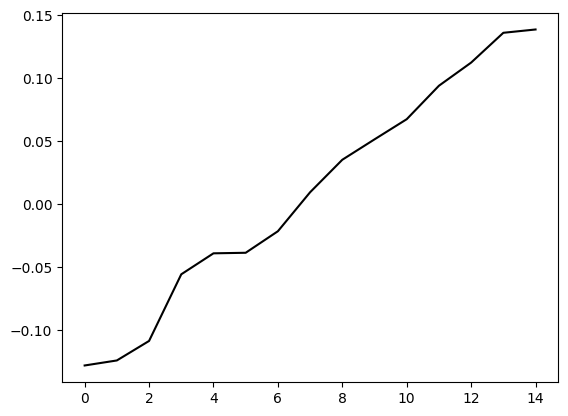

In [129]:
# what is our average difference in odds?
VO['odds_comparison'] = VO['hometeamodds'] - VO['hometeamodds_dk']

ovalues = VO['odds_comparison'].values
plt.plot(ovalues[np.argsort(ovalues)],color='black')

In [132]:
outlierthreshold = 0.15
winthreshold = 0.6
pot = 1000.0
betsize = 100.
houseedge = 0.01

def run_bets(VO,pot,outlierthreshold,winthreshold,betsize,houseedge):

    for game in range(0,len(VO['odds_comparison'].values)):
        oddsdiff = VO['odds_comparison'].values[game]
        homeodds = VO['hometeamodds'].values[game]
        homeoddsdk = VO['hometeamodds_dk'].values[game]
        homewin = VO['hometeamwin'].values[game]
        hometeam = VO['hometeamfull'].values[game]
        awayteam = VO['awayteamfull'].values[game]
        dateval = VO['date_x'].values[game]

        # we are favouring the home team: bet them
        if (oddsdiff > outlierthreshold) & (homeodds > winthreshold):
            print('{4}: Betting on {0} to beat {1} with odds {2}: {3} ({5})'.format(hometeam,awayteam,homeoddsdk,homewin,dateval,np.round(pot,0)))

            if homewin:
                pot += compute_winloss(homeoddsdk,input=betsize,houseedge=houseedge) - betsize
            else:
                pot -= betsize

        # we are favouring the away team: bet them
        if (oddsdiff < -outlierthreshold) & (homeodds < 1-winthreshold):
            print('{4}: Betting on {0} to beat {1} with odds {2}: {3} ({5})'.format(awayteam,hometeam,homeoddsdk,not homewin,dateval,np.round(pot,0)))

            if not homewin:
                pot += compute_winloss(homeoddsdk,input=betsize,houseedge=houseedge) - betsize
            else:
                pot -= betsize

        
    return pot
        

print(run_bets(VO,pot,outlierthreshold,winthreshold,betsize,houseedge))

1000.0


In [38]:
# get the days in the season
date_range = pd.date_range(start='2024-05-11', end='2024-09-29')
days_list = [(date.month, date.day) for date in date_range]


IndexError: index 0 is out of bounds for axis 0 with size 0

2024-05-11: Betting on Minnesota Twins to beat Toronto Blue Jays with odds 0.5829926396165348: False (1000.0)
2024-05-11: Betting on Washington Nationals to beat Boston Red Sox with odds 0.5933697527596193: False (900.0)
2024-05-11: Betting on Philadelphia Phillies to beat Miami Marlins with odds 0.4572564613405057: True (800.0)
2024-05-14: Betting on Los Angeles Angels to beat St. Louis Cardinals with odds 0.4365079376463042: False (917.0)
2024-05-17: Betting on Colorado Rockies to beat San Francisco Giants with odds 0.5996387716075958: False (817.0)
2024-05-18: Betting on Colorado Rockies to beat San Francisco Giants with odds 0.6369041809336118: False (717.0)
2024-05-19: Betting on Cleveland Guardians to beat Minnesota Twins with odds 0.5217391295274103: True (617.0)
2024-05-19: Betting on Miami Marlins to beat New York Mets with odds 0.4365079376463042: False (706.0)
2024-05-19: Betting on Detroit Tigers to beat Arizona Diamondbacks with odds 0.5829926396165348: False (606.0)
2024-

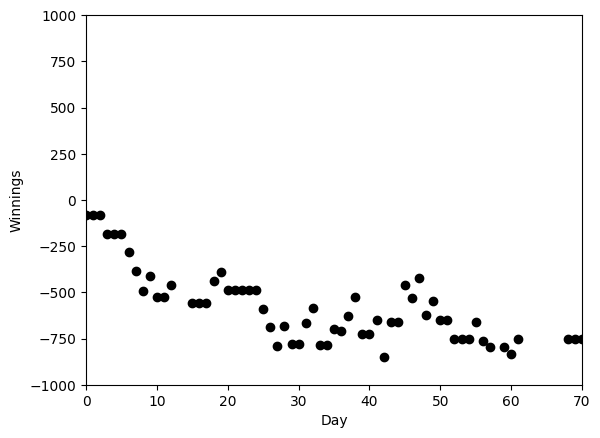

In [136]:
totalo,totalg = 0,0
ovalues = []
pot = 1000.0
outlierthreshold = 0.15
winthreshold = 0.6


for day_indx,day in enumerate(days_list):
    try:
        O = get_odds(*day,hour='12')
        V = get_validation(*days_list[day_indx+1])
        VO = pd.merge(V,O,left_on=['hometeamfull','awayteamfull'],right_on=['hometeamfull','awayteamfull'])
        VO['checkou'] = (VO['hometeamscore'] + VO['awayteamscore']) > VO['ou']
        totalo += VO['checkou'].sum()
        totalg += VO['checkou'].size

        # check the prediction values
        # what we think, versus what the bookies think
        # if positive, we think the home team will win more than the bookies
        # so we should bet on the home team. if negative, we should bet on the away team
        # with some threshold (and have to predict home team to actually win)
        VO['odds_comparison'] = VO['hometeamodds'] - VO['hometeamodds_dk']

        pot = run_bets(VO,pot,outlierthreshold,winthreshold,betsize,houseedge)
        plt.scatter(day_indx,pot-1000.,color='black')

        ovalues.extend(VO['odds_comparison'].values)
    except:
        print(day)


plt.xlabel('Day')
plt.ylabel('Winnings')
plt.axis([0,70,-1000,1000])
print(totalo,totalg,totalo/totalg)

(array([ 1.,  0.,  0.,  2.,  0.,  0.,  1.,  3.,  6.,  7.,  6.,  7., 10.,
         8., 20., 14., 16., 29., 31., 34., 35., 36., 36., 47., 48., 48.,
        44., 43., 32., 34., 40., 29., 19., 18., 15., 15., 10., 12.,  9.,
         4.,  5.,  3.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-0.38759842, -0.37318764, -0.35877687, -0.34436609, -0.32995532,
        -0.31554454, -0.30113376, -0.28672299, -0.27231221, -0.25790144,
        -0.24349066, -0.22907989, -0.21466911, -0.20025834, -0.18584756,
        -0.17143679, -0.15702601, -0.14261524, -0.12820446, -0.11379369,
        -0.09938291, -0.08497214, -0.07056136, -0.05615059, -0.04173981,
        -0.02732904, -0.01291826,  0.00149251,  0.01590329,  0.03031406,
         0.04472484,  0.05913561,  0.07354639,  0.08795716,  0.10236794,
         0.11677872,  0.13118949,  0.14560027,  0.16001104,  0.17442182,
         0.18883259,  0.20324337,  0.21765414,  0.23206492,  0.24647569,
         0.26088647,  0.27529724,  0.28970802,  0.30411879,

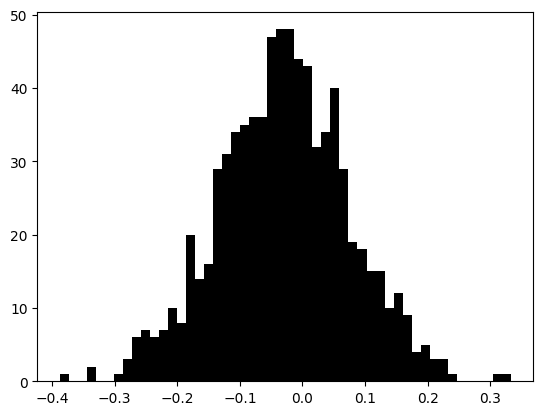

In [137]:
ovalues = np.array(ovalues)
plt.hist(ovalues[np.argsort(ovalues)],color='black',bins=50)
